In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import importanceMatrix
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt

In [86]:
#Import dermatology data
proj_path = os.path.dirname(os.getcwd())
col_names = np.array([
    'erythema', 'scaling', 'definite borders',
    'itching', 'koebner phenomenon', 'polygonal papules',
    'follicular papules', 'oral mucosal involvement', 'knee and elbow involvement',
    'scalp involvement', 'family history', 'melanin incontinence',
    'eosinophils in the infiltrate', 'PNL infiltrate', 'fibrosis of the papillary dermis',
    'exocytosis', 'acanthosis', 'hyperkeratosis',
    'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges',
    'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
    'focal hypergranulosis', 'disappearance of the granular layer',
    'vacuolisation and damage of basal layer',
    'spongiosis', 'saw-tooth appearance of retes', 'follicular horn plug',
    'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate',
    'band-like infiltrate',
    'Age', 'Class'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = col_names[:-1]
#clinical_feature_names = np.hstack([col_names[:11], np.array(['Age'])])
class_names = np.array(['psoriasis', 'seboreic dermatitis', 'lichen planus',
                        'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'])
class_names = np.array([lab.capitalize() for lab in class_names])
class_tags = np.arange(len(class_names)) + 1
data = pd.read_csv(proj_path+'/0_data/dermatology.data', header=None, names=col_names)
skip_rows = data.Age == '?'
#skip_rows.sum()
data = data[~skip_rows]
data.Age = np.array(data.Age, dtype=int)

In [87]:
X = np.array(data.loc[:,col_names[:-1]])
y = np.array(data.loc[:,col_names[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)

# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Mean Absolute Error: 0.02
Model Accuracy: 98.89
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


In [140]:
"""
#prediction with clinical attributes only
print(col_names[:11])
X = np.array(data.loc[:,clinical_feature_names])
y = np.array(data.loc[:,col_names[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)

# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
"""

['Erythema' 'Scaling' 'Definite borders' 'Itching' 'Koebner phenomenon'
 'Polygonal papules' 'Follicular papules' 'Oral mucosal involvement'
 'Knee and elbow involvement' 'Scalp involvement' 'Family history']
Mean Absolute Error: 0.24
Model Accuracy: 90.0
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


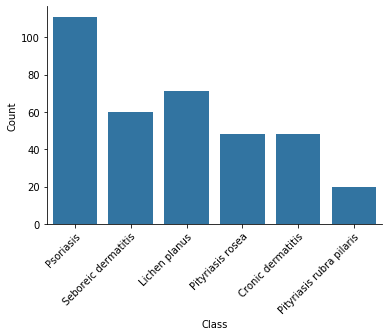

In [88]:
###Class count plot
fig, ax = plt.subplots()
sns.countplot(y, color=sns.color_palette()[0], ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
sns.despine(fig=fig)

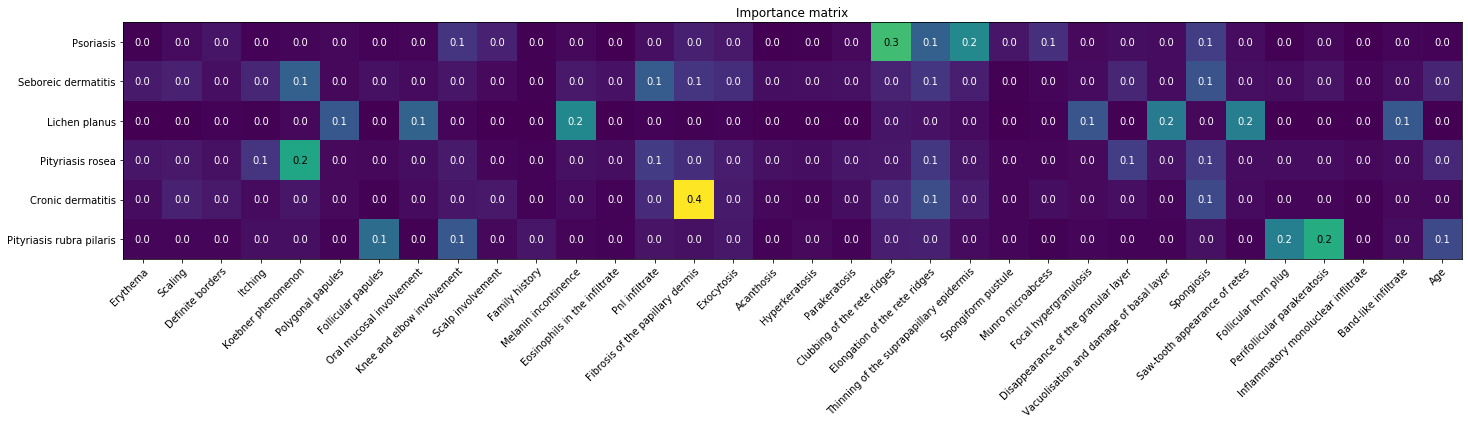

In [89]:
###IMPORTANCE MATRIX

# calculate the importance matrix
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)

# plot the result
fig, ax = plt.subplots(figsize=(len(feature_names), len(class_names)))
im = ax.imshow(imp_mat)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat.shape[1]))
ax.set_yticks(np.arange(imp_mat.shape[0]))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(class_names)

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
thresh = imp_mat.max() / 2.
for i in range(len(class_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, round(imp_mat[i, j], 1), ha="center", va="center",
                       color="black" if imp_mat[i, j] > thresh else "white")
        
ax.set_title("Importance matrix")
fig.tight_layout()
plt.show()

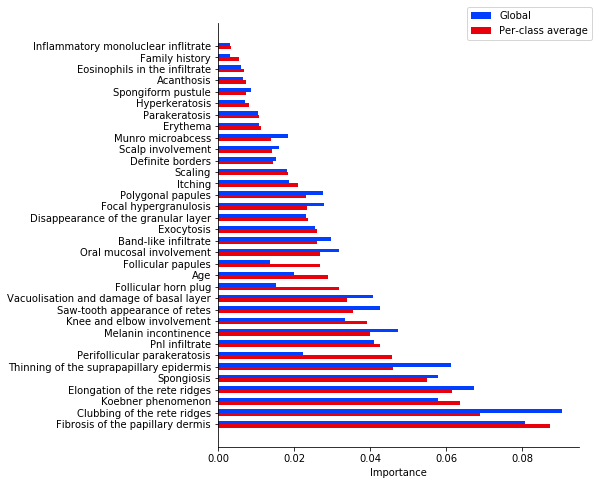

In [90]:
###GLOBAL VS PER-CLASS AVERAGE IMPORTANCE
fig, ax = plt.subplots(figsize=(len(feature_names)/4, len(feature_names)/5))
global_importance = rf_clf.feature_importances_
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
imp_index = np.argsort(mean_importance)
height = 0.3
y_g = np.arange(len(imp_index))[::-1] + (height / 2.)
y_m = np.arange(len(imp_index))[::-1] - (height / 2.)
ax.barh(y=y_g, width=global_importance[imp_index], height=height,
        color=sns.color_palette('bright')[0], label='Global')
ax.barh(y=y_m, width=mean_importance[imp_index], height=height,
        color=sns.color_palette('bright')[3], label='Per-class average')
ax.set_xlabel('Importance')
ax.set_yticks(np.arange(len(imp_index))[::-1])
ax.set_yticklabels(feature_names[imp_index])
ax.legend(bbox_to_anchor=(1.05, 1.05))
sns.despine(fig=fig)
fig.tight_layout()
#fig.savefig(proj_dir+'/2_output/img/GO_log10p_bars.pdf', bbox_inches='tight')
plt.show()

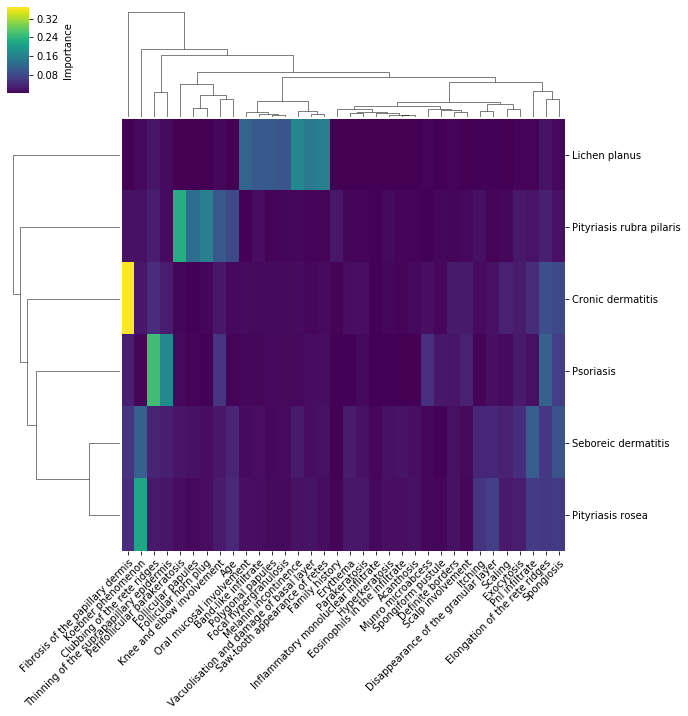

In [91]:
#Heatmap
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
#X_train, y_train
df_imp_mat = pd.DataFrame(imp_mat, columns=feature_names, index=class_names)
cluster_heatmap = sns.clustermap(df_imp_mat, cmap="viridis",
                                 method='average',
                                 cbar_kws={'label':'Importance'},
                                 col_cluster=True, row_cluster=True,
                                 yticklabels=True)
                                 #mask = mask_non_significant)
#cluster_heatmap.savefig('Importance_matrix_heatmap.pdf', bbox_inches='tight')
plt.setp(cluster_heatmap.ax_heatmap.xaxis.get_majorticklabels(),
         rotation=45, ha="right", rotation_mode="anchor")
plt.show()
plt.close()

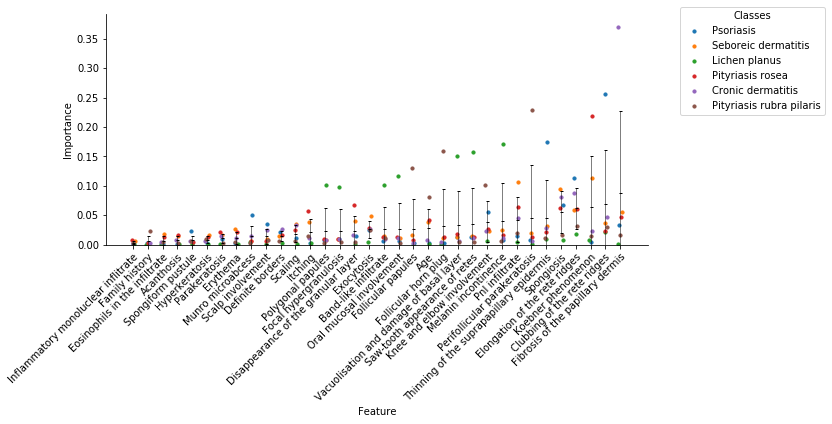

In [92]:
#importance distribution over features
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_imp = np.mean(imp_mat, axis=0)
std_imp = np.std(imp_mat, axis=0, ddof=1)
df_imp_mat = pd.DataFrame(imp_mat, columns=feature_names)
feature_index = np.argsort(mean_imp)
features_reord = feature_names[feature_index]

marker_lst = [
    "o", "v", "^", "<", ">", "1", "2", "3", "4",
    "8", "s", "p", "P", "*", "h", "H", "+", "x",
    "X", "D", "d"
]
color_lst = sns.color_palette(n_colors=10)
color_marker_lst = np.array([(c,m) for m in marker_lst for c in color_lst])

fig, ax = plt.subplots(figsize=(len(feature_names)/3.5, len(feature_names)/8))
for j,i in enumerate(feature_index):
    ax.plot([j,j,j], [mean_imp[i]+std_imp[i], mean_imp[i], mean_imp[i]-std_imp[i]],
            marker='_', color='k', ls='-', lw=0.5, ms=3)
for j in np.arange(len(imp_mat)):
    ax.scatter(np.arange(len(feature_index))+np.random.uniform(-1, 1, size=len(feature_index))*.25/2.,
               imp_mat[j,feature_index],
               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=10, label=class_names[j])
    
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Classes')
ax.set_xticks(np.arange(len(feature_index)))
ax.set_xticklabels(features_reord, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig('Importance_matrix_distribution.pdf', bbox_inches='tight')
plt.show()

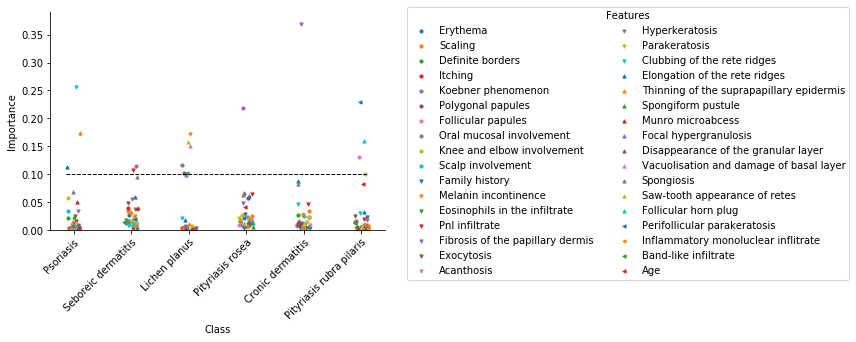

In [93]:
#importance distribution over classes
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
#mean_imp = np.mean(imp_mat, axis=1)
#std_imp = np.std(imp_mat, axis=1, ddof=1)
#class_index = np.argsort(mean_imp)
#classes_reord = np.array(wines.target_names)[class_index]
#classes = class_names
#features = feature_names

marker_lst = [
    "o", "v", "^", "<", ">", "1", "2", "3", "4",
    "8", "s", "p", "P", "*", "h", "H", "+", "x",
    "X", "D", "d"
]
color_lst = sns.color_palette(n_colors=10)
color_marker_lst = np.array([(c,m) for m in marker_lst for c in color_lst])

fig, ax = plt.subplots()
#for j,i in enumerate(class_index):
#    ax.plot([j]*len(mean_imp), [mean_imp[i]+std_imp[i], mean_imp[i], mean_imp[i]-std_imp[i]],
#            marker='_', color='k', ls='-', lw=0.5, ms=3)
#for j in np.arange(len(features)):
#    ax.scatter(np.arange(len(class_index))[class_index] + np.random.uniform(-1,1,size=len(class_index))*.25/2.,
#               imp_mat[class_index,j],
#               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
#               s=10, label=features[j])
for j in np.arange(len(feature_names)):
    ax.scatter(np.arange(len(class_names)) + np.random.uniform(-1,1,size=len(class_names))*.25/2.,
               imp_mat[:,j],
               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=10, label=feature_names[j])
ax.hlines(y=0.1, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig('Importance_matrix_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

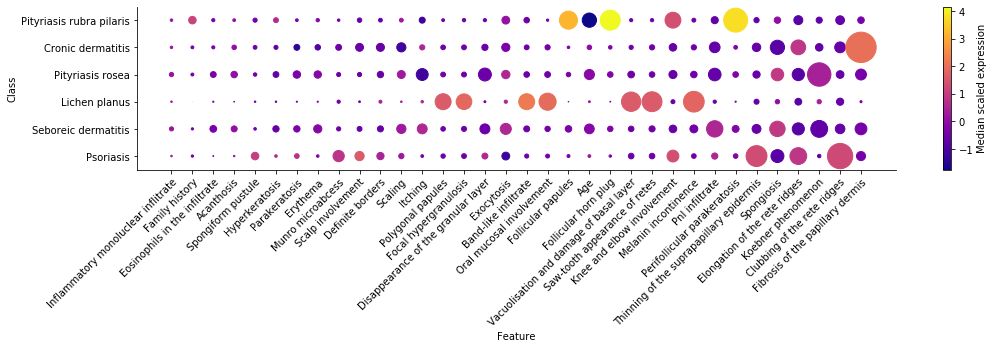

In [94]:
#Feature importance and median expression
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)

#Order classes
#mean_imp_per_class = np.mean(imp_mat, axis=1)
#class_index = np.argsort(mean_imp_per_class)
#classes_reord = np.arange(len((class_names)))[class_index]
#classes_name_reord = class_names[class_index]
#classes = class_names
#Order features
mean_imp_per_feat = np.mean(imp_mat, axis=0)
feat_index = np.argsort(mean_imp_per_feat)
feat_reord = feature_names[feat_index]

imp_mat_reord = imp_mat[:,feat_index]

norm_X = scale(X)

x_pos = np.hstack([np.arange(1,len(feat_reord)+1) for k in range(len(class_names))])
y_pos = np.hstack([np.ones(len(feat_reord))*(k+1) for k in range(len(class_names))])
sizes = imp_mat_reord * 2500
medians = np.array([
    np.median(norm_X[y==cl,f_ind]) for cl in class_tags for f_ind in feat_index
])
#sizes = np.ones(np.shape(imp_mat_reord)) * 2500
fig, ax = plt.subplots(figsize=(len(feat_reord)/2, len(class_names)/2))
sc = ax.scatter(x=x_pos, y=y_pos, s=sizes, c=medians, cmap='plasma')

#ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features')
plt.colorbar(sc, label='Median scaled expression')
ax.set_yticks(np.arange(1,len(class_names)+1))
ax.set_yticklabels(class_names)
ax.set_xticks(np.arange(1,len(feat_reord)+1))
ax.set_xticklabels(feat_reord, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Class')
ax.set_xlabel('Feature')

ax.set_ylim(bottom=0.5, top=len(class_names)+0.5)
sns.despine(fig=fig)
#fig.savefig('Importance_matrix_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [95]:
global_importance = rf_clf.feature_importances_
global_index = np.argsort(global_importance)

imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
pca_index = np.argsort(mean_importance)

unique_classes, count_classes = np.unique(y, return_counts=True)
rare_class_ind = np.argsort(count_classes)[0]
rare_class = unique_classes[rare_class_ind]
rare_class_index = np.argsort(imp_mat[rare_class_ind])

top5_global_features = feature_names[global_index[-5:]]
top5_pca_features = feature_names[pca_index[-5:]]
top5_rare_features = feature_names[rare_class_index[-5:]]
print(top5_global_features)
print(top5_pca_features)
print(top5_rare_features)

['Spongiosis' 'Thinning of the suprapapillary epidermis'
 'Elongation of the rete ridges' 'Fibrosis of the papillary dermis'
 'Clubbing of the rete ridges']
['Spongiosis' 'Elongation of the rete ridges' 'Koebner phenomenon'
 'Clubbing of the rete ridges' 'Fibrosis of the papillary dermis']
['Age' 'Knee and elbow involvement' 'Follicular papules'
 'Follicular horn plug' 'Perifollicular parakeratosis']


In [96]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.plasma):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, label='Percentage')
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(round(cm[i, j],0), fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")
    fig.tight_layout()
    return ax

Mean Absolute Error: 0.57
Model Accuracy: 70.0


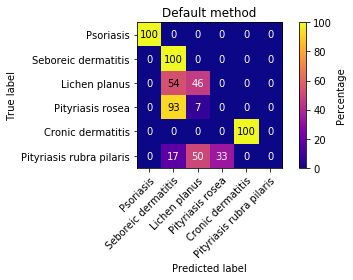

In [97]:
feat_ind = np.array([feat in top5_global_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

plot_confusion_matrix(y_test, predictions, class_names,
                      title='Default method')
plt.show()

Mean Absolute Error: 0.32
Model Accuracy: 83.33


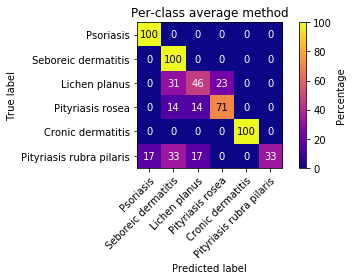

In [100]:
feat_ind = np.array([feat in top5_pca_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

plot_confusion_matrix(y_test, predictions, class_names,
                      title='Per-class average method')
plt.show()

Mean Absolute Error: 0.78
Model Accuracy: 54.44


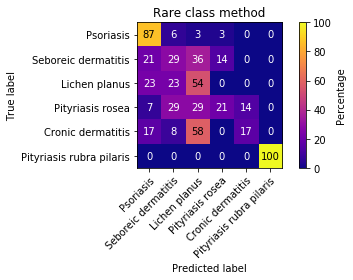

In [99]:
feat_ind = np.array([feat in top5_rare_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

plot_confusion_matrix(y_test, predictions, class_names,
                      title='Rare class method')
plt.show()